In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df.head()

,home_win,away_win,draw,home_possLostAll,away_possLostAll,home_shotFastbreak,away_shotFastbreak,home_lastManTackle,away_lastManTackle,home_totalFinalThirdPasses,...,home_ballRecovery,away_ballRecovery,home_cornerTaken,away_cornerTaken,home_cornerTaken.1,away_cornerTaken.1,home_fouledFinalThird,away_fouledFinalThird,home_dispossessed,away_dispossessed
0,1,0,0,147,132,2,0,0,0,228,...,55,52,8,0,8,0,1,2,8,6
1,1,0,0,164,163,1,0,0,0,127,...,64,60,8,1,8,1,5,8,9,15
2,1,0,0,161,183,0,0,0,0,129,...,71,73,5,3,5,3,4,2,6,11
3,1,0,0,160,168,0,0,0,0,100,...,69,63,4,3,4,3,4,0,7,9
4,0,0,1,143,147,1,1,0,0,107,...,62,62,3,8,3,8,4,1,5,6


In [4]:

df = pd.read_csv("data.csv")


In [15]:
training = df.iloc[:-20] #select all the rows except for the last 20
test = df.iloc[-20:] #select the last 20 rows

In [16]:
#normalize the data between 0 and 1
for e in range(3, len(training.columns)): #iterate for each column
    num = max(training.iloc[:, e].max(), test.iloc[:, e].max()) #check the maximum value in each column
    if num < 10:
        training.iloc[:, e] /= 10
        test.iloc[:, e] /= 10
    elif num < 100:
        training.iloc[:, e] /= 100
        test.iloc[:, e] /= 100
    elif num < 1000:
        training.iloc[:, e] /= 1000
        test.iloc[:, e] /= 1000
    elif num < 10000:
        training.iloc[:, e] /= 10000
        test.iloc[:, e] /= 10000
    else:
        print("Error in normalization! Please check!")

In [17]:
training = training.sample(frac=1) #shuffle the training data
test = test.sample(frac=1) #shuffle the test data

In [18]:
#all rows, all columns except for the last 3 columns
training_input  = training.iloc[:, 3:]
#all rows, the last 3 columns
training_output = training.iloc[:, :3]
#all rows, all columns except for the last 3 columns
test_input  = test.iloc[:, 3:]
#all rows, the last 3 columns
test_output = test.iloc[:, :3]

In [20]:
# separating the output into two classes: win or draw-defeat
# for the winners convert the output: 
# from (1, 0, 0) to 1 
# from (0, 1, 0) to 0 
# from (0, 0, 1) to 0
def convert_output_win(source):
    target = source.copy() # make a copy from source
    target['new'] = 2 # create a new column with any value
    for i, rows in target.iterrows():
        if rows['home_win'] == 1:
            rows['new'] = 0
        if rows['draw'] == 1:
            rows['new'] = 1
        if rows['away_win'] == 1:
            rows['new'] = 0
    return target.iloc[:, -1]  # return all rows, the last column
training_output = convert_output_win(training_output)
test_output = convert_output_win(test_output)

In [21]:
training_input = torch.FloatTensor(training_input.values)
training_output = torch.FloatTensor(training_output.values)
test_input = torch.FloatTensor(test_input.values)
test_output = torch.FloatTensor(test_output.values)

In [22]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid() 
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [23]:
input_size = training_input.size()[1] # number of features selected
hidden_size = 50 # number of nodes/neurons in the hidden layer
model = Net(input_size, hidden_size) # create the model
criterion = torch.nn.BCELoss() # works for binary classification
# without momentum parameter
optimizer = torch.optim.SGD(model.parameters(), lr = 0.9) 
#with momentum parameter
optimizer = torch.optim.SGD(model.parameters(), lr = 0.9, momentum=0.2)

In [24]:
model.eval()
y_pred = model(test_input)
print(y_pred)

tensor([[0.4375],
        [0.4361],
        [0.4477],
        [0.4382],
        [0.4383],
        [0.4445],
        [0.4429],
        [0.4400],
        [0.4421],
        [0.4395],
        [0.4456],
        [0.4399],
        [0.4391],
        [0.4394],
        [0.4403],
        [0.4341],
        [0.4443],
        [0.4381],
        [0.4376],
        [0.4433]], grad_fn=<SigmoidBackward0>)


In [25]:
model.train()
epochs = 5000
errors = []
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(training_input)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), training_output)
    errors.append(loss.item())
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

In [28]:
model.eval()
y_pred = model(test_input)
print(y_pred)
after_train = criterion(y_pred.squeeze(), test_output)


tensor([[0.1393],
        [0.0603],
        [0.3177],
        [0.2468],
        [0.0246],
        [0.2823],
        [0.2165],
        [0.3451],
        [0.1590],
        [0.2791],
        [0.0486],
        [0.1455],
        [0.3529],
        [0.3412],
        [0.3412],
        [0.1449],
        [0.2355],
        [0.0525],
        [0.1584],
        [0.2550]], grad_fn=<SigmoidBackward0>)


In [27]:
test_output

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0.])

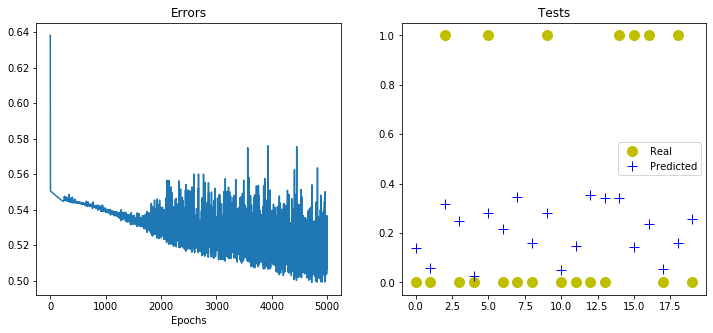

In [29]:
def plotcharts(errors):
    errors = np.array(errors)
    plt.figure(figsize=(12, 5))
    graf02 = plt.subplot(1, 2, 1) # nrows, ncols, index
    graf02.set_title('Errors')
    plt.plot(errors, '-')
    plt.xlabel('Epochs')
    graf03 = plt.subplot(1, 2, 2)
    graf03.set_title('Tests')
    a = plt.plot(test_output.numpy(), 'yo', label='Real')
    plt.setp(a, markersize=10)
    a = plt.plot(y_pred.detach().numpy(), 'b+', label='Predicted')
    plt.setp(a, markersize=10)
    plt.legend(loc=7)
    plt.show()
plotcharts(errors)

tensor([[0.8999],
        [0.6045],
        [0.0357],
        [0.0619],
        [0.3671],
        [0.5160],
        [0.3005],
        [0.0036],
        [0.6575],
        [0.0597],
        [0.2353],
        [0.1047],
        [0.2027],
        [0.7212],
        [0.0711],
        [0.8731],
        [0.3248],
        [0.0939],
        [0.0016],
        [0.6396]], grad_fn=<SigmoidBackward0>)

In [31]:
test_output

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0.])